In [ ]:
import numpy as np
import pickle
from pathlib import Path
import torch
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

### Generate embeddings wth SIGLIP, CLIP, and VILT from collected trajectory buffer

In [ ]:
# Enter the path to your collected trajectory dataset pkl file
INPUT_PKL = Path("your path here/text2nav/buffer_with_orientations.pkl")

# Choose model type: 'siglip', 'clip', or 'vilt'
MODEL_TYPE = "vilt"
OUTPUT_PKL = INPUT_PKL.parent / f"replay_buffer_with_embeddings_{MODEL_TYPE}.pkl"

In [ ]:
from transformers import SiglipProcessor, SiglipModel

class SigLIPMatcher:
    def __init__(self, model_name="google/siglip-so400m-patch14-384", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = SiglipProcessor.from_pretrained(model_name)
        self.model = SiglipModel.from_pretrained(model_name).to(self.device).eval()

    def _l2(self, x):
        return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    @torch.no_grad()
    def get_joint_embeddings(self, images, prompts):
        img_inp = self.processor(images=images, return_tensors="pt").to(self.device)
        img_feat = self._l2(self.model.get_image_features(**img_inp))
        txt_inp = self.processor(text=prompts, return_tensors="pt", padding=True).to(self.device)
        txt_feat = self._l2(self.model.get_text_features(**txt_inp))
        joint = self._l2(img_feat + txt_feat)
        return joint

In [ ]:
from transformers import CLIPProcessor, CLIPModel

class CLIPMatcher:
    def __init__(self, model_name="openai/clip-vit-base-patch32", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(self.device).eval()

    def _l2(self, x):
        return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    @torch.no_grad()
    def get_joint_embeddings(self, images, prompts):
        # Process images and text separately for CLIP
        img_inputs = self.processor(images=images, return_tensors="pt").to(self.device)
        txt_inputs = self.processor(text=prompts, return_tensors="pt", padding=True).to(self.device)

        # Get image and text features separately
        img_feat = self._l2(self.model.get_image_features(**img_inputs))
        txt_feat = self._l2(self.model.get_text_features(**txt_inputs))

        # Combine features (similar to SigLIP approach)
        joint = self._l2(img_feat + txt_feat)
        return joint

In [ ]:
from transformers import ViltProcessor, ViltModel

class ViLTMatcher:
    def __init__(self, model_name="dandelin/vilt-b32-finetuned-vqa", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = ViltProcessor.from_pretrained(model_name)
        self.model = ViltModel.from_pretrained(model_name).to(self.device).eval()

    def _l2(self, x):
        return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    @torch.no_grad()
    def get_joint_embeddings(self, images, prompts):
        # ViLT processes image and text together
        inputs = self.processor(images=images, text=prompts, return_tensors="pt", padding=True).to(self.device)
        outputs = self.model(**inputs)

        # Use pooler_output for joint representation
        pooled_output = outputs.pooler_output  # shape: (batch_size, hidden_size)
        return self._l2(pooled_output)

In [ ]:
class EmbeddingPipeline:
    def __init__(self, model_type="siglip"):
        """
        Initialize embedding pipeline with specified model type.

        Args:
            model_type (str): One of 'siglip', 'clip', or 'vilt'
        """
        self.model_type = model_type
        if model_type == "siglip":
            self.matcher = SigLIPMatcher()
        elif model_type == "clip":
            self.matcher = CLIPMatcher()
        elif model_type == "vilt":
            self.matcher = ViLTMatcher()
        else:
            raise ValueError(f"Unknown model type: {model_type}. Choose from 'siglip', 'clip', or 'vilt'")

        print(f"Initialized {model_type.upper()} embedding pipeline")

    def generate(self, image: torch.Tensor, prompts):
        """
        Generate joint embeddings for the given image and prompts.

        Args:
            image (torch.Tensor): Input image tensor. (N, 3, 256, 256)
            prompts (list): List of text prompts

        Returns:
            embeddings (torch.Tensor): Tensor of joint embeddings.
        """
        embeddings = self.matcher.get_joint_embeddings(image, prompts)
        return embeddings

In [ ]:
# Load the replay buffer
with open(INPUT_PKL, "rb") as f:
    buffer = pickle.load(f)

print(f"Loaded buffer with {len(buffer)} items")

In [ ]:
# Extract components from replay buffer
replay_buffer = buffer
rgbs = np.array([item[0] for item in replay_buffer])
goal_indices = np.array([item[1] for item in replay_buffer])
angles = np.array([item[2] for item in replay_buffer])
actions = np.array([item[3] for item in replay_buffer])
rewards = np.array([item[4] for item in replay_buffer])
dones = np.array([item[5] for item in replay_buffer])
truncateds = np.array([item[6] for item in replay_buffer])

print(f"Data shapes: RGB={rgbs.shape}, Goals={goal_indices.shape}, Angles={angles.shape}")
print(f"Actions={actions.shape}, Rewards={rewards.shape}, Dones={dones.shape}, Truncated={truncateds.shape}")

In [ ]:
# Color mapping for prompts
COLOR_INDEX = {
    "red": 0,
    "green": 1,
    "blue": 2,
    "yellow": 3,
    "pink": 4
}
INDEX_COLOR = {v: k for k, v in COLOR_INDEX.items()}

print(f"Color mapping: {INDEX_COLOR}")

In [ ]:
def generate_relative_prompts(y, goal_index, INDEX_COLOR, y_thresh=0.2, base="Move toward the ball."):
    """
    Generate relative position prompts based on goal angle.

    Args:
        y: angle values (relative y-coordinate)
        goal_index: target color indices
        INDEX_COLOR: mapping from index to color name
        y_thresh: threshold for left/right classification
        base: base instruction text

    Returns:
        List of prompt strings
    """
    prompts = []

    for i in range(len(y)):
        color = INDEX_COLOR[int(goal_index[i])]
        if y[i] > y_thresh:
            prompts.append(f"The target is {color} ball which is to your left. {base}")
        elif y[i] < -y_thresh:
            prompts.append(f"The target is {color} ball which is to your right. {base}")
        else:
            prompts.append(f"The target is {color} ball which is straight ahead. {base}")

    return prompts

In [ ]:
# Initialize pipeline with the MODEL_TYPE set at the top
embedding_pipeline = EmbeddingPipeline(model_type=MODEL_TYPE)

In [ ]:
def thread_worker(i):
    """
    Worker function for parallel processing of embeddings.
    """
    try:
        rgb = rgbs[i]
        angle = angles[i]
        goal_index = goal_indices[i]
        prompts = generate_relative_prompts(angle, goal_index, INDEX_COLOR=INDEX_COLOR)
        embedding = embedding_pipeline.generate(rgb, prompts)
        return i, embedding.cpu().numpy()
    except Exception as e:
        print(f"Error processing item {i}: {e}")
        return i, None

In [ ]:
# Generate embeddings using parallel processing
embeddings_buffer = [None] * len(rgbs)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(thread_worker, i) for i in range(len(rgbs))]

    for future in tqdm(as_completed(futures), total=len(futures), desc=f"Generating {MODEL_TYPE.upper()} embeddings"):
        idx, embedding = future.result()
        if embedding is not None:
            embeddings_buffer[idx] = embedding
        else:
            print(f"Failed to process item {idx}")

# Convert to numpy array
embeddings_buffer = np.array(embeddings_buffer)
print(f"Generated embeddings shape: {embeddings_buffer.shape}")

In [ ]:
# Create replay buffer with embeddings
replay_buffer_with_embeddings = []
for i in range(len(rgbs)):
    replay_buffer_with_embeddings.append((
        embeddings_buffer[i],
        actions[i],
        rewards[i],
        dones[i],
        truncateds[i]
    ))

print(f"Created replay buffer with {len(replay_buffer_with_embeddings)} items")

In [ ]:
# Save embeddings buffer for future use
embeddings_filename = f"embeddings_buffer_{MODEL_TYPE}.pkl"
with open(embeddings_filename, "wb") as f:
    pickle.dump(replay_buffer_with_embeddings, f)

print(f"Embeddings saved as {embeddings_filename}")

### If you already have a embedding file, you can verify your embedding with the following code and convert it into an MDP dataset for d3rlpy

In [ ]:
import pickle
import numpy as np

# Choose which embeddings to load and verify
MODEL_TO_VERIFY = "siglip"  # Change to "clip" to verify the other file

# Load the appropriate embeddings file
if MODEL_TO_VERIFY == "siglip":
    embeddings_filename = "new_prompts_embeddings.pkl"
elif MODEL_TO_VERIFY == "vilt":
    embeddings_filename = "embeddings_buffer_vilt.pkl"
elif MODEL_TO_VERIFY == "clip":
    embeddings_filename = "embeddings_buffer_clip.pkl"
else:
    raise ValueError("MODEL_TO_VERIFY must be 'siglip' 'vilt' or 'clip'")

print(f"Loading {embeddings_filename}...")

# Load the embeddings buffer
with open(embeddings_filename, "rb") as f:
    replay_buffer_with_embeddings = pickle.load(f)

print(f"Loaded {len(replay_buffer_with_embeddings)} items from {embeddings_filename}")

# Quick preview of structure
print(f"First item structure: {type(replay_buffer_with_embeddings[0])}")
if len(replay_buffer_with_embeddings) > 0:
    item = replay_buffer_with_embeddings[0]
    print(f"Tuple length: {len(item)}")
    print(f"Embedding shape: {item[0].shape if hasattr(item[0], 'shape') else type(item[0])}")
    print(f"Actions shape: {item[1].shape if hasattr(item[1], 'shape') else type(item[1])}")
    print(f"Rewards shape: {item[2].shape if hasattr(item[2], 'shape') else type(item[2])}")
    print(f"Dones shape: {item[3].shape if hasattr(item[3], 'shape') else type(item[3])}")
    print(f"Truncated shape: {item[4].shape if hasattr(item[4], 'shape') else type(item[4])}")

print(f"\nReady to run verification cells for {MODEL_TO_VERIFY.upper()} embeddings!")

Loading new_prompts_embeddings.pkl...
Loaded 5000 items from new_prompts_embeddings.pkl
First item structure: <class 'tuple'>
Tuple length: 5
Embedding shape: (32, 1152)
Actions shape: (32, 2)
Rewards shape: (32, 1)
Dones shape: (32, 1)
Truncated shape: (32, 1)

Ready to run verification cells for SIGLIP embeddings!


In [9]:
# Extract and slice data for episode boundaries
embedds = np.array([item[0] for item in replay_buffer_with_embeddings])
actions_rb = np.array([item[1] for item in replay_buffer_with_embeddings])
rewards_rb = np.array([item[2] for item in replay_buffer_with_embeddings])
dones_rb = np.array([item[3] for item in replay_buffer_with_embeddings])
truncateds_rb = np.array([item[4] for item in replay_buffer_with_embeddings])

print(f"Data shapes before slicing:")
print(f"Embeddings: {embedds.shape}, Actions: {actions_rb.shape}")
print(f"Rewards: {rewards_rb.shape}, Dones: {dones_rb.shape}, Truncated: {truncateds_rb.shape}")

Data shapes before slicing:
Embeddings: (5000, 32, 1152), Actions: (5000, 32, 2)
Rewards: (5000, 32, 1), Dones: (5000, 32, 1), Truncated: (5000, 32, 1)


In [5]:
# Slice data based on episode boundaries
embedds_sliced = []
actions_sliced = []
rewards_sliced = []
dones_sliced = []
truncateds_sliced = []

for i in range(embedds.shape[1]):
    done_mask = dones_rb[:, 0, :] > 0
    truncated_mask = truncateds_rb[:, 0, :] > 0

    # Element-wise OR to find episode ends
    final_mask = np.logical_or(done_mask, truncated_mask)

    # Get the indices where episodes end
    indices = np.where(final_mask)[0]
    if len(indices) > 0:
        last_index = indices[-1] + 1
    else:
        last_index = embedds.shape[0]

    embedds_sliced.append(embedds[:last_index, i, :])
    actions_sliced.append(actions_rb[:last_index, i, :])
    rewards_sliced.append(rewards_rb[:last_index, i, :])
    dones_sliced.append(dones_rb[:last_index, i, :])
    truncateds_sliced.append(truncateds_rb[:last_index, i, :])

# Stack all sliced data
embedds_sliced = np.vstack(embedds_sliced)
actions_sliced = np.vstack(actions_sliced)
rewards_sliced = np.vstack(rewards_sliced)
dones_sliced = np.vstack(dones_sliced)
truncateds_sliced = np.vstack(truncateds_sliced)

print(f"Data shapes after slicing:")
print(f"Embeddings: {embedds_sliced.shape}, Actions: {actions_sliced.shape}")
print(f"Rewards: {rewards_sliced.shape}, Dones: {dones_sliced.shape}, Truncated: {truncateds_sliced.shape}")

Data shapes after slicing:
Embeddings: (156672, 1152), Actions: (156672, 2)
Rewards: (156672, 1), Dones: (156672, 1), Truncated: (156672, 1)


In [7]:
import d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import TD3PlusBCConfig
from d3rlpy.preprocessing import MinMaxActionScaler

In [8]:
def create_dataset(embeddings, actions, rewards, dones, truncateds):
    """
    Create MDP dataset for d3rlpy training.
    """
    dataset = MDPDataset(
        observations=embeddings,
        actions=actions,
        rewards=rewards,
        terminals=dones,
        timeouts=truncateds,
        action_space=d3rlpy.constants.ActionSpace.CONTINUOUS,
    )
    return dataset

# Create dataset
dataset = create_dataset(
    embeddings=embedds_sliced,
    actions=actions_sliced,
    rewards=rewards_sliced,
    dones=dones_sliced,
    truncateds=truncateds_sliced
)

print(f"Created dataset with {len(embedds_sliced)} transitions")

2025-05-28 21:34.44 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(2,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(1152,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-05-28 21:34.44 [info     ] Action size has been automatically determined. action_size=2
Created dataset with 156672 transitions


In [ ]:
# Setup TD3+BC algorithm
algorithm = TD3PlusBCConfig(
    batch_size=256, 
    action_scaler=MinMaxActionScaler()
).create(device="cuda:0" if torch.cuda.is_available() else "cpu")

algorithm.build_with_dataset(dataset)
print("Algorithm initialized and built with dataset")

In [ ]:
# Train the model
print(f"Starting training with {MODEL_TYPE.upper()} embeddings...")

algorithm.fit(
    dataset,
    n_steps=100000,  # Reduced for testing - increase for full training
    save_interval=10000,
)

print("Training completed!")

In [ ]:
# Save the trained model
model_filename = f"td3_plus_bc_{MODEL_TYPE}_model.pkl"
algorithm.save_model(model_filename)
print(f"Model saved as {model_filename}")

### Model inference evaluation and summary

ViLT data shape: (167, 2)
CLIP data shape: (150, 2)
SigLIP data shape: (101, 2)

ViLT columns: ['Success', 'Timesteps']
CLIP columns: ['Success', 'Timesteps']
SigLIP columns: ['Success', 'Timesteps']

After removing first row:
ViLT episodes: 166
CLIP episodes: 149
SigLIP episodes: 100

After truncating to first 100 episodes for fair comparison:
ViLT episodes: 100
CLIP episodes: 100
SigLIP episodes: 100

Success Rates (Fair Comparison - n=100 each):
ViLT: 40.0%
CLIP: 62.0%
SigLIP: 74.0%

Average Timesteps (Successful Episodes):
ViLT: 472.0
CLIP: 417.6
SigLIP: 369.4


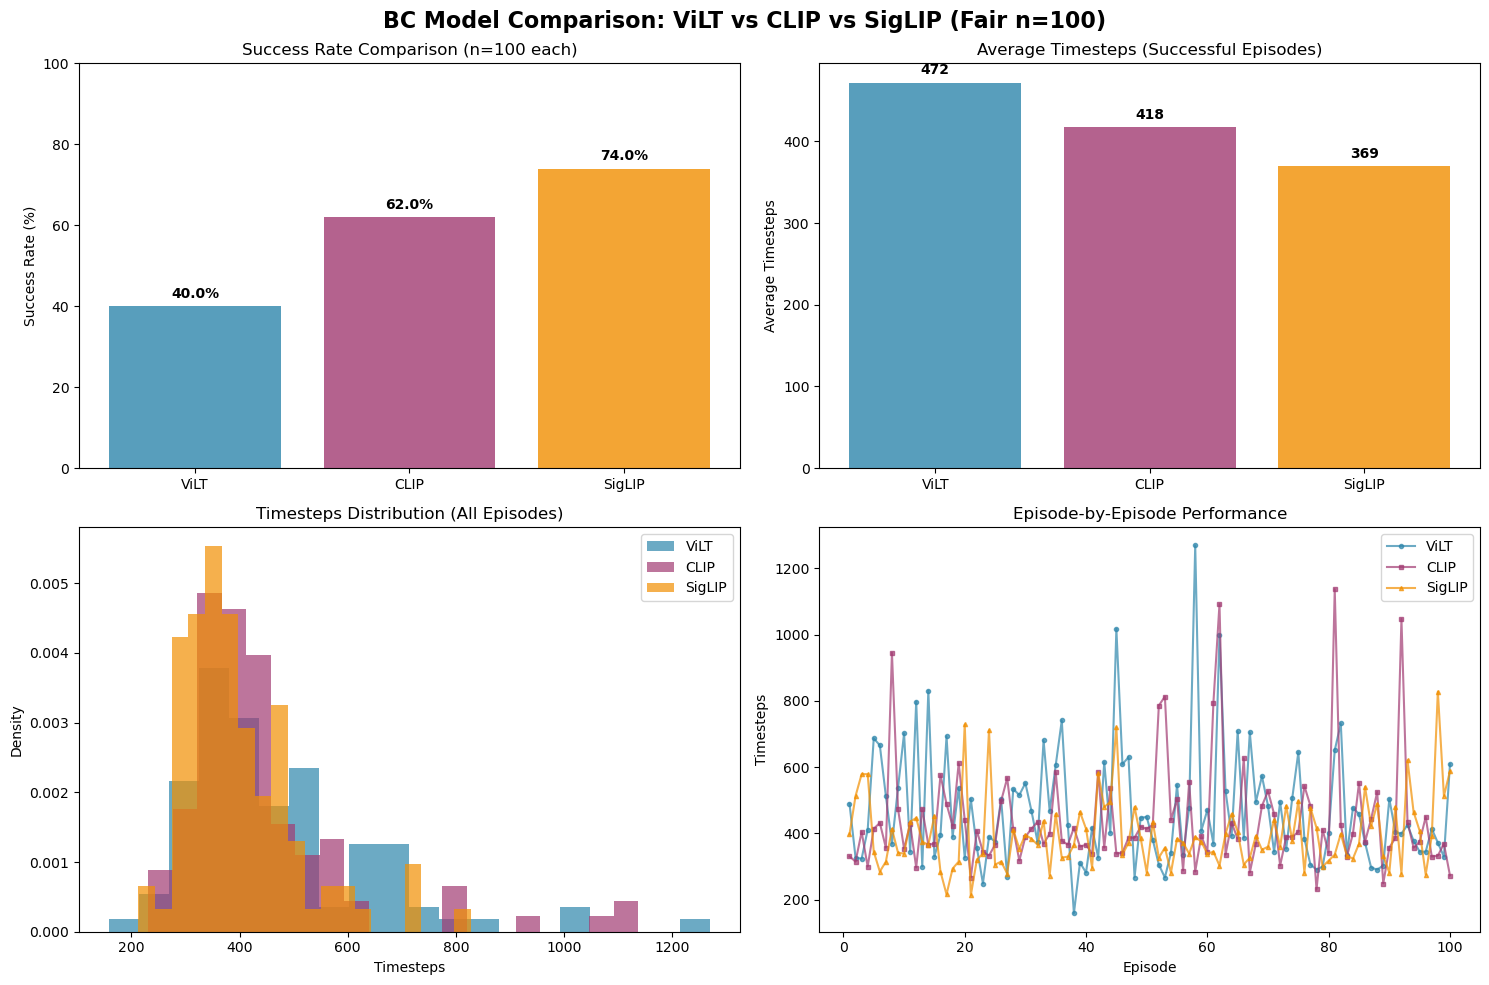


DETAILED STATISTICS (FAIR COMPARISON - n=100 each)

ViLT Performance:
  Success Rate: 40.0%
  Successful Episodes: 40/100
  Avg Timesteps (Success): 472.0
  Min Timesteps (Success): 249
  Max Timesteps (Success): 741

CLIP Performance:
  Success Rate: 62.0%
  Successful Episodes: 62/100
  Avg Timesteps (Success): 417.6
  Min Timesteps (Success): 249
  Max Timesteps (Success): 813

SigLIP Performance:
  Success Rate: 74.0%
  Successful Episodes: 74/100
  Avg Timesteps (Success): 369.4
  Min Timesteps (Success): 216
  Max Timesteps (Success): 828

FAIR COMPARISON SUMMARY (n=100 each)
Highest Success Rate: SigLIP (74.0%)
Most Efficient: SigLIP (369.4 timesteps)

Success Rate Ranking:
  1. SigLIP: 74.0%
  2. CLIP: 62.0%
  3. ViLT: 40.0%

Efficiency Ranking (fewer timesteps = better):
  1. SigLIP: 369.4 timesteps
  2. CLIP: 417.6 timesteps
  3. ViLT: 472.0 timesteps

Success Rates with 95% Confidence Intervals (n=100 each):
ViLT: 40.0% [30.4% - 49.6%]
CLIP: 62.0% [52.5% - 71.5%]
SigLIP: 74

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV files
vilt_data = pd.read_csv('bc_vilt_eval.csv')
clip_data = pd.read_csv('bc_clip_eval.csv')
siglip_data = pd.read_csv('extras_with_bc.csv')

print("ViLT data shape:", vilt_data.shape)
print("CLIP data shape:", clip_data.shape)
print("SigLIP data shape:", siglip_data.shape)
print("\nViLT columns:", vilt_data.columns.tolist())
print("CLIP columns:", clip_data.columns.tolist())
print("SigLIP columns:", siglip_data.columns.tolist())

# Remove the first row (timestep 0, value 0)
vilt_data = vilt_data.iloc[1:].reset_index(drop=True)
clip_data = clip_data.iloc[1:].reset_index(drop=True)
siglip_data = siglip_data.iloc[1:].reset_index(drop=True)

print(f"\nAfter removing first row:")
print(f"ViLT episodes: {len(vilt_data)}")
print(f"CLIP episodes: {len(clip_data)}")
print(f"SigLIP episodes: {len(siglip_data)}")

# Truncate all datasets to first 100 episodes for fair comparison
vilt_data = vilt_data.iloc[:100].reset_index(drop=True)
clip_data = clip_data.iloc[:100].reset_index(drop=True)
siglip_data = siglip_data.iloc[:100].reset_index(drop=True)

print(f"\nAfter truncating to first 100 episodes for fair comparison:")
print(f"ViLT episodes: {len(vilt_data)}")
print(f"CLIP episodes: {len(clip_data)}")
print(f"SigLIP episodes: {len(siglip_data)}")

# Calculate success rates
vilt_success_rate = vilt_data['Success'].mean() * 100
clip_success_rate = clip_data['Success'].mean() * 100
siglip_success_rate = siglip_data['Success'].mean() * 100

print(f"\nSuccess Rates (Fair Comparison - n=100 each):")
print(f"ViLT: {vilt_success_rate:.1f}%")
print(f"CLIP: {clip_success_rate:.1f}%")
print(f"SigLIP: {siglip_success_rate:.1f}%")

# Calculate average timesteps (only for successful episodes)
vilt_successful = vilt_data[vilt_data['Success'] == 1]
clip_successful = clip_data[clip_data['Success'] == 1]
siglip_successful = siglip_data[siglip_data['Success'] == 1]

vilt_avg_timesteps = vilt_successful['Timesteps'].mean()
clip_avg_timesteps = clip_successful['Timesteps'].mean()
siglip_avg_timesteps = siglip_successful['Timesteps'].mean()

print(f"\nAverage Timesteps (Successful Episodes):")
print(f"ViLT: {vilt_avg_timesteps:.1f}")
print(f"CLIP: {clip_avg_timesteps:.1f}")
print(f"SigLIP: {siglip_avg_timesteps:.1f}")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('BC Model Comparison: ViLT vs CLIP vs SigLIP (Fair n=100)', fontsize=16, fontweight='bold')

# Define colors for consistency
colors = ['#2E86AB', '#A23B72', '#F18F01']
model_names = ['ViLT', 'CLIP', 'SigLIP']

# Plot 1: Success Rate Comparison
success_rates = [vilt_success_rate, clip_success_rate, siglip_success_rate]
bars1 = axes[0, 0].bar(model_names, success_rates, color=colors, alpha=0.8)
axes[0, 0].set_ylabel('Success Rate (%)')
axes[0, 0].set_title('Success Rate Comparison (n=100 each)')
axes[0, 0].set_ylim(0, 100)
for i, v in enumerate(success_rates):
    axes[0, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 2: Average Timesteps Comparison (Successful Episodes)
avg_timesteps = [vilt_avg_timesteps, clip_avg_timesteps, siglip_avg_timesteps]
bars2 = axes[0, 1].bar(model_names, avg_timesteps, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('Average Timesteps')
axes[0, 1].set_title('Average Timesteps (Successful Episodes)')
for i, v in enumerate(avg_timesteps):
    axes[0, 1].text(i, v + 10, f'{v:.0f}', ha='center', fontweight='bold')

# Plot 3: Timesteps Distribution
axes[1, 0].hist(vilt_data['Timesteps'], bins=20, alpha=0.7, label='ViLT', color=colors[0], density=True)
axes[1, 0].hist(clip_data['Timesteps'], bins=20, alpha=0.7, label='CLIP', color=colors[1], density=True)
axes[1, 0].hist(siglip_data['Timesteps'], bins=20, alpha=0.7, label='SigLIP', color=colors[2], density=True)
axes[1, 0].set_xlabel('Timesteps')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Timesteps Distribution (All Episodes)')
axes[1, 0].legend()

# Plot 4: Episode-by-Episode Performance
episodes = range(1, 101)  # Now all have exactly 100 episodes

axes[1, 1].plot(episodes, vilt_data['Timesteps'], 'o-', alpha=0.7, label='ViLT', color=colors[0], markersize=3)
axes[1, 1].plot(episodes, clip_data['Timesteps'], 's-', alpha=0.7, label='CLIP', color=colors[1], markersize=3)
axes[1, 1].plot(episodes, siglip_data['Timesteps'], '^-', alpha=0.7, label='SigLIP', color=colors[2], markersize=3)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Timesteps')
axes[1, 1].set_title('Episode-by-Episode Performance')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('bc_fair_comparison_n100.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print(f"\n" + "="*60)
print("DETAILED STATISTICS (FAIR COMPARISON - n=100 each)")
print("="*60)

print(f"\nViLT Performance:")
print(f"  Success Rate: {vilt_success_rate:.1f}%")
print(f"  Successful Episodes: {len(vilt_successful)}/100")
print(f"  Avg Timesteps (Success): {vilt_avg_timesteps:.1f}")
if len(vilt_successful) > 0:
    print(f"  Min Timesteps (Success): {vilt_successful['Timesteps'].min()}")
    print(f"  Max Timesteps (Success): {vilt_successful['Timesteps'].max()}")

print(f"\nCLIP Performance:")
print(f"  Success Rate: {clip_success_rate:.1f}%")
print(f"  Successful Episodes: {len(clip_successful)}/100")
print(f"  Avg Timesteps (Success): {clip_avg_timesteps:.1f}")
if len(clip_successful) > 0:
    print(f"  Min Timesteps (Success): {clip_successful['Timesteps'].min()}")
    print(f"  Max Timesteps (Success): {clip_successful['Timesteps'].max()}")

print(f"\nSigLIP Performance:")
print(f"  Success Rate: {siglip_success_rate:.1f}%")
print(f"  Successful Episodes: {len(siglip_successful)}/100")
print(f"  Avg Timesteps (Success): {siglip_avg_timesteps:.1f}")
if len(siglip_successful) > 0:
    print(f"  Min Timesteps (Success): {siglip_successful['Timesteps'].min()}")
    print(f"  Max Timesteps (Success): {siglip_successful['Timesteps'].max()}")

# Performance comparison (3-way)
models_performance = {
    'ViLT': {'success': vilt_success_rate, 'timesteps': vilt_avg_timesteps},
    'CLIP': {'success': clip_success_rate, 'timesteps': clip_avg_timesteps},
    'SigLIP': {'success': siglip_success_rate, 'timesteps': siglip_avg_timesteps}
}

# Find best performing models
best_success_model = max(models_performance.keys(), key=lambda x: models_performance[x]['success'])
best_efficiency_model = min(models_performance.keys(), key=lambda x: models_performance[x]['timesteps'])

print(f"\n" + "="*60)
print("FAIR COMPARISON SUMMARY (n=100 each)")
print("="*60)
print(f"Highest Success Rate: {best_success_model} ({models_performance[best_success_model]['success']:.1f}%)")
print(f"Most Efficient: {best_efficiency_model} ({models_performance[best_efficiency_model]['timesteps']:.1f} timesteps)")

# Ranking by success rate
success_ranking = sorted(models_performance.items(), key=lambda x: x[1]['success'], reverse=True)
print(f"\nSuccess Rate Ranking:")
for i, (model, stats) in enumerate(success_ranking, 1):
    print(f"  {i}. {model}: {stats['success']:.1f}%")

# Ranking by efficiency (lower timesteps = better)
efficiency_ranking = sorted(models_performance.items(), key=lambda x: x[1]['timesteps'])
print(f"\nEfficiency Ranking (fewer timesteps = better):")
for i, (model, stats) in enumerate(efficiency_ranking, 1):
    print(f"  {i}. {model}: {stats['timesteps']:.1f} timesteps")

# Add confidence intervals for the fair comparison
from scipy import stats

def confidence_interval(success_count, total_episodes, confidence=0.95):
    """Calculate binomial confidence interval"""
    if total_episodes == 0:
        return 0, 0
    p = success_count / total_episodes
    z = stats.norm.ppf((1 + confidence) / 2)
    margin = z * np.sqrt(p * (1 - p) / total_episodes)
    return max(0, p - margin) * 100, min(100, p + margin) * 100

print(f"\nSuccess Rates with 95% Confidence Intervals (n=100 each):")
models_data = {'ViLT': vilt_data, 'CLIP': clip_data, 'SigLIP': siglip_data}

for name, data in models_data.items():
    success_count = data['Success'].sum()
    total = len(data)
    success_rate = success_count / total * 100
    ci_low, ci_high = confidence_interval(success_count, total)
    print(f"{name}: {success_rate:.1f}% [{ci_low:.1f}% - {ci_high:.1f}%]")

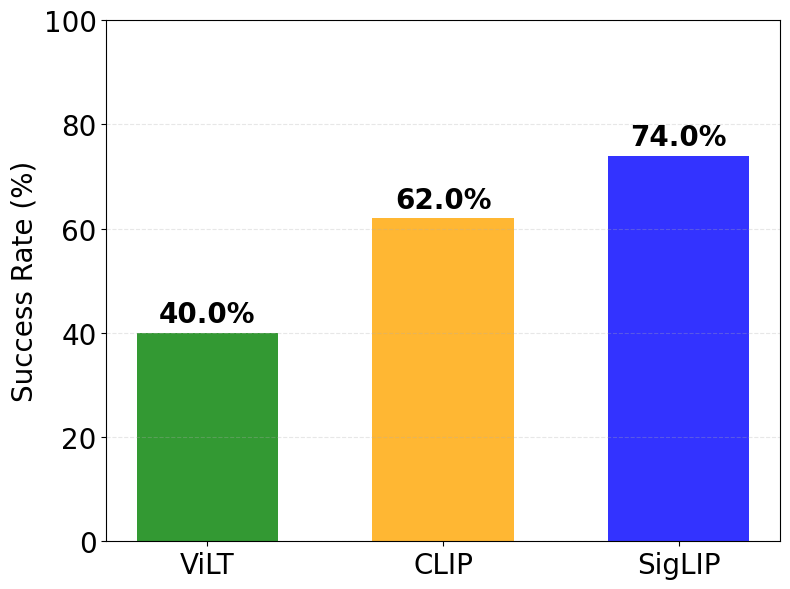

Figure 5 saved as 'bc_success_comparison.png'


In [31]:
# Create Figure 5: Success Rate Comparison Bar Chart
import matplotlib.pyplot as plt
import numpy as np

# Data from your analysis
model_names = ['ViLT', 'CLIP', 'SigLIP']
success_rates = [40.0, 62.0, 74.0]
colors = ['green', 'orange', 'blue']  # ViLT=green, CLIP=orange, SigLIP=blue

# Create figure
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, success_rates, color=colors, alpha=0.8, width=0.6)

# Customize the plot
plt.ylabel('Success Rate (%)', fontsize=20)
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(success_rates):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=20)

# Make x-axis and y-axis labels larger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Customize appearance
plt.tight_layout()

# Save the figure
plt.savefig('bc_success_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('bc_success_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5 saved as 'bc_success_comparison.png'")